# Predictive Modeling Strategies

Transitioning from **Unsupervised Clustering** to **Supervised Machine Learning**.

### Step 0: Data Preparation (Crucial)

**Remove Outlier Cluster 4**
Before applying any of the strategies below, you must drop **Cluster 4**.
*   **Reason:** It contains only **N=1** person. Machine Learning models cannot learn patterns from a single example, and splitting data into Train/Test sets is mathematically impossible for a class of size 1.

```python
# Sample Code
# Filter out the outlier cluster before modeling
df_model = df_cluster[df['cluster'] != 4].copy()
# Drop Temporal Leakage Columns ("Year" and "PredictionYear")
# These are metadata, not patient features.
cols_to_drop = ['Year', 'PredictionYear']
existing_drop_cols = [c for c in cols_to_drop if c in df_model.columns]
```

### Core Modeling Strategies (Choose one or compare both)

#### Strategy A: Cluster-Specific Specialist Models (The "Divide and Conquer" Approach)

**Combines "Divide and Conquer" with "Cluster-Specific Specialist Models"**

Instead of training one mediocre model for everyone, train separate regressors—one for each specific cluster.

- The Logic: A feature like `hincome_03` is a massive driver for Cluster 1 ("Ultra-Wealthy"), but it is statistically irrelevant for `Cluster 0` ("Frail & Vulnerable"), where `Num_ADL` dominates. A single global model often struggles to learn these contradicting rules simultaneously.
- Implementation:
    1) Split the df_model data by cluster.
    2) Train a separate regressor (e.g., Random Forest or XGBoost) for each distinct valid group (0, 1, 2, 3, 5).
    3) Inference: When a new patient arrives, first predict their cluster (using the saved K-Means model), then pass them to the specific specialist model for that cluster to get the final score prediction.

#### Strategy B: Cluster ID as a "Meta-Feature" (Global Model)

**Combines "Cluster as a Feature" with "Cluster ID as a Meta-Feature"**

If managing multiple models is too complex, train one global model but explicitly provide the cluster context.

- The Logic: Add the cluster column (0, 1, 2, 3, 5) as a categorical feature (or One-Hot Encoded) in the input matrix X.
- Implementation:

    - Tree-based models (like Random Forest) will use this feature to create "interaction splits."
    - Example: The tree learns: IF cluster == 0 AND physical_health == poor THEN score is low... but IF cluster == 5 AND physical_health == poor THEN score is moderate. It effectively learns context-aware rules.
<hr>

#### Data Improvement Strategy (Apply to A or B)

##### Strategy C: Cluster-Based Oversampling for Minority Groups

**Addresses "Small N" in valid clusters like the Ultra-Wealthy**

After dropping Cluster 4, Cluster 1 ("The Ultra-Wealthy") is your new minority group with only N=57 people, while the middle cohorts have hundreds.
- The Logic: A standard model minimizes global error, meaning it will likely ignore the 57 wealthy people to optimize for the majority. It will fail to predict well for wealthy outliers.
- Implementation:
    - Oversampling: Duplicate the rows of Cluster 1 (and potentially Cluster 2) in the training set until they are statistically significant.
    - SMOTE: Use Synthetic Minority Over-sampling Technique to generate synthetic examples of "Ultra-Wealthy" people to balance the dataset before training.

<hr>

#### Alternative Task Strategy

##### Strategy D: The "Triage" Classifier (Predicting the Persona)

**Predicting the Cluster itself**

Instead of predicting the score, predicting the Cluster ID is a valuable clinical Machine Learning task.

- The Logic: A doctor might not have time to measure a "Composite Score" immediately. However, if they input basic demographics and the model predicts: "This patient is in Cluster 0 (Frail & Vulnerable)," they immediately know the risk profile (depression/mobility issues) without running the full cognitive test.
- Implementation:
    - Target Variable: cluster (Classes: 0, 1, 2, 3, 5)
    - Algorithm: Random Forest Classifier
    - Goal: Maximize F1-Score (Macro) to ensure small classes are identified correctly.

<hr>

#### Advanced Interpretation Strategy

##### Strategy E: SHAP Analysis per Cluster

**Explainable AI**

Use SHAP (SHapley Additive exPlanations) to explain why the predictions are happening, validating that the clusters are distinct entities.

- The Logic: Global feature importance plots can be misleading. A feature that is important globally might be irrelevant for a specific subgroup.
- Implementation:
    - Calculate SHAP values for the test set.
    - Plot SHAP summary charts specifically for the subset of data in Cluster 0 vs. Cluster 5.
    - Expected Result: You will likely see Num_Illnesses has a high SHAP value (high negative impact) for Cluster 0, but a low SHAP value for Cluster 1 (where Money/Assets take over).

In [1]:
import os
import sys

# print(f"Current Working Directory --> {os.getcwd()}")
#Add one directory above research
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..")) # Get the parent directory
sys.path.append(parent_dir)
current_working_dir = %pwd

print(f"Parent Dir >>> {parent_dir}")
print(f"Current Working Dir >>> {current_working_dir}")

# from configs import cfgs  # Absolute import

Parent Dir >>> C:\Users\maz\dev\Projects_\alzheimer
Current Working Dir >>> C:\Users\maz\dev\Projects_\alzheimer\research


In [2]:
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

### 1. Imports And Setup

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import joblib  # For saving models
from pathlib import Path
import pprint
import ipywidgets as widgets
from IPython.display import display
import math

# Machine Learning Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import chi2_contingency

# Visualization Settings
%matplotlib inline
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

pp = pprint.PrettyPrinter(indent=2)

# Custom Functions
from utils import *

print("Libraries Loaded Successfully.")

Libraries Loaded Successfully.


### Paths

In [4]:
# Create a path object
# dataset_dir = cfgs["DATASET_DIR"]
dataset_dir = "..//dataset//modified"
dataset_path = Path(dataset_dir)
print("Dataset Path")
print("*"*12)
print(f"Dataset: {dataset_path}")
print("\n")

# Find all CSV files inside the directory
files = list(dataset_path.glob("*.csv"))

print("Files in Dataset Dir:")
print("*"*21)
for file_path in files:
    print(file_path.name)  # Print only the file name


# Combining multiple paths
# path_metadata = dataset_path / "MetaData.xlsx"
path_train = dataset_path / "train.csv"
path_test = dataset_path / "test.csv"
path_train_new = dataset_path / "train_without_featEng.csv"
path_train_new_clustered = dataset_path / "train_with_clusters.csv"

print("\n")
print(f"Train File Path --> {path_train}")
print(f"Train File Path --> {path_train_new_clustered}")

# Define the path to save the trained models
models_dir = "..//models//strategyA"
models_dir = Path(models_dir)
models_dir.mkdir(exist_ok=True)
print("\n")
print("Libraries Loaded. Models will be saved to:", models_dir)

Dataset Path
************
Dataset: ..\dataset\modified


Files in Dataset Dir:
*********************
test.csv
test_features.csv
test_labels.csv
train.csv
train_features.csv
train_labels.csv
train_with_clusters.csv


Train File Path --> ..\dataset\modified\train.csv
Train File Path --> ..\dataset\modified\train_with_clusters.csv


Libraries Loaded. Models will be saved to: ..\models\strategyA


#### 2. Data Loading

##### We will load data from `train_with_clusters.csv` which was saved in notebook `c_clustering.ipynb`

In [5]:
# Load the clustered dataset
try:
    df = pd.read_csv(path_train_new_clustered)
    print(f"Data Loaded Successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: File not found.")

# --- STEP 0: Remove Anomalies & Leakage ---

# 1. Remove Cluster 4 (The outlier with N=1)
df_model = df[df['cluster'] != 4].copy()

# 2. Drop Temporal Leakage Columns
# We drop 'Year' and 'PredictionYear' so the model relies on PATIENT data, not the DATE.
cols_to_drop = ['Year', 'PredictionYear']
existing_drop_cols = [c for c in cols_to_drop if c in df_model.columns]

if existing_drop_cols:
    df_model = df_model.drop(existing_drop_cols, axis=1)
    print(f"Removed leakage columns: {existing_drop_cols}")

print(f"Final Data Shape for Modeling: {df_model.shape}")

Data Loaded Successfully. Shape: (2889, 161)
Removed leakage columns: ['Year', 'PredictionYear']
Final Data Shape for Modeling: (2888, 159)


### 3. PRE-PROCESSING PIPELINE

In [6]:
# Define X (Features) and y (Target)
X = df_model.drop(['composite_score', 'cluster'], axis=1) 
y = df_model['composite_score']
cluster_labels = df_model['cluster'] # Keep this for splitting logic

# Identify Column Types automatically
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Define the Preprocessing Steps
preprocessor = ColumnTransformer(
    transformers=[
        # Scale numeric features (optional for RF, but safer)
        ('num', StandardScaler(), numeric_features),
        # One-Hot Encode categorical features (handle_unknown='ignore' is crucial for production)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    verbose_feature_names_out=False
)

print(f"Pipeline Configured: {len(numeric_features)} Numeric features, {len(categorical_features)} Categorical features.")

Pipeline Configured: 122 Numeric features, 35 Categorical features.


### 4. STRATEGY A: TRAIN CLUSTER-SPECIFIC SPECIALIST MODELS

In [7]:
valid_clusters = [0, 1, 2, 3, 5]
specialist_models = {}  
cluster_metrics = []   

print("--- Starting Training Loop: Cluster-Specific Specialists ---")

for c_id in valid_clusters:
    print(f"\nTraining Specialist Model for Cluster {c_id}...")
    
    # 1. Isolate Data for this Cluster
    indices = cluster_labels[cluster_labels == c_id].index
    X_cluster = X.loc[indices]
    y_cluster = y.loc[indices]
    
    # 2. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_cluster, y_cluster, test_size=0.2, random_state=42
    )
    
    # 3. Create Pipeline
    # Random Forest proved to be the most robust model in our preliminary tests
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
    ])
    
    # 4. Train
    model_pipeline.fit(X_train, y_train)
    
    # 5. Evaluate
    preds = model_pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    # 6. Store Results
    cluster_metrics.append({
        'Cluster': c_id,
        'N_Samples': len(X_cluster),
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })
    
    # 7. Save Model
    # We save the entire pipeline (preprocessor + model)
    model_filename = f"specialist_model_cluster_{c_id}.pkl"
    joblib.dump(model_pipeline, models_dir / model_filename)
    
    # Keep in memory for the comparison step below
    specialist_models[c_id] = {
        'model': model_pipeline,
        'X_test': X_test,
        'y_test': y_test,
        'preds': preds
    }

    print(f"   -> MAE: {mae:.2f} | R2: {r2:.3f} | Model Saved.")

print("\n--- Training Complete ---")

--- Starting Training Loop: Cluster-Specific Specialists ---

Training Specialist Model for Cluster 0...
   -> MAE: 33.51 | R2: 0.314 | Model Saved.

Training Specialist Model for Cluster 1...
   -> MAE: 38.27 | R2: 0.331 | Model Saved.

Training Specialist Model for Cluster 2...
   -> MAE: 29.48 | R2: 0.498 | Model Saved.

Training Specialist Model for Cluster 3...
   -> MAE: 32.96 | R2: 0.448 | Model Saved.

Training Specialist Model for Cluster 5...
   -> MAE: 29.98 | R2: 0.593 | Model Saved.

--- Training Complete ---


### 5. PERFORMANCE SUMMARY & VISUALIZATION


Model Performance by Cluster:


,N_Samples,MAE,RMSE,R2
Cluster,,,,
0,652,33.511628,41.783827,0.313622
1,57,38.265496,55.217636,0.330677
2,346,29.476031,39.878814,0.498341
3,997,32.961511,43.457829,0.448270
5,836,29.981910,38.516773,0.593245


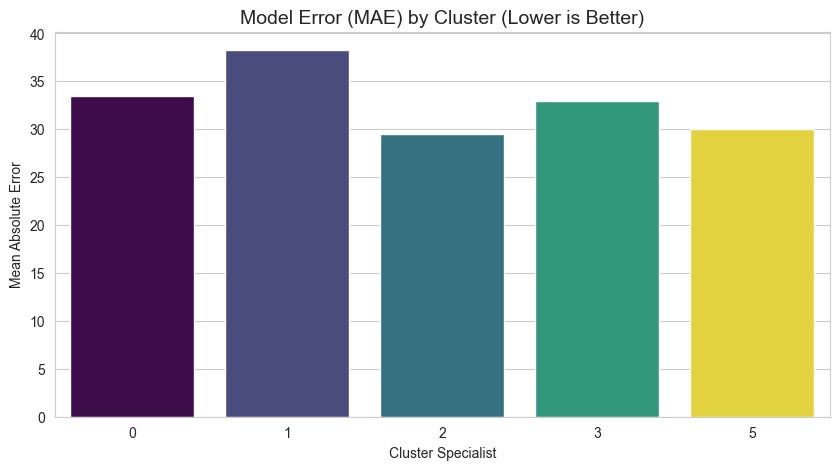

In [8]:
metrics_df = pd.DataFrame(cluster_metrics)

# Display styled table
print("\nModel Performance by Cluster:")
display(metrics_df.set_index('Cluster').style.background_gradient(cmap='RdYlGn', subset=['MAE', 'R2']))
print("\n")

# Plot MAE
plt.figure(figsize=(10, 5))

# FIX: Added hue='Cluster' and legend=False to silence the warning
sns.barplot(x='Cluster', y='MAE', hue='Cluster', data=metrics_df, palette='viridis', legend=False)

plt.title("Model Error (MAE) by Cluster (Lower is Better)", fontsize=14)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cluster Specialist")
plt.show()

### Interpretation of Model Performance Results


**1. The Metrics Explained (How to Read the Table)**
    
   - **MAE (Mean Absolute Error):** The average "miss" distance. `Lower is better`.
        - Example: An `MAE of 30 means`, on average, the model's prediction is off by `+/- 30 points` from the actual cognitive score.
   - **R2 (R-Squared):** How much of the variation in the score is explained by the model. `Higher is better (closer to 1.0)`.
        - `0.50+` is considered good for complex `human/health` data.
        - `< 0.30` indicates the model is struggling to find a pattern.

<hr>

**2. The "Star Performer": `Cluster 5 ("High-Earning Professionals")`**
    
- **R2:** `0.59 (Highest) | MAE: 29.98 (Low)`
- **Analysis:** This is your best model. It explains nearly `60%` of the variance in cognitive scores, which is excellent for behavioral health data.
- **Why?** This group follows a predictable pattern. `High education`, `steady employment`, and `good health` are strong, consistent predictors of cognitive performance. The model understands this group very well.

<hr>

**3. The "Most Accurate": `Cluster 2 ("Working Middle Cohort")`**

- **MAE:** `29.47 (Lowest Error) | R2: 0.49 (Strong)`
- **Analysis:** While `Cluster 5` has a better `R2`, `Cluster 2` actually has the lowest average error.
- **Why?** This group represents `"average"` working people. They likely don't have the extreme outliers (very sick or very rich) that confuse models, making them the "easiest" to predict accurately.

<hr>

**4. The "Problem Child": `Cluster 1 ("The Ultra-Wealthy")`**

- **MAE:** `38.26 (Worst Error) | R2: 0.33 (Low)`
- **Analysis:** The model struggles significantly here. It has the highest error rate.
- **Why?**
    1) Sample Size: `N=57 `is simply too small for Machine Learning. The model cannot learn a robust rule set from so few examples.
    2) Wealth Effect: At extremely `high income levels`, standard predictors (like "Do you have a job?") stop mattering. Their cognitive scores might be driven by factors we didn't measure (e.g., quality of private healthcare, leisure activities).

<hr>

**5. The "Hardest to Explain": `Cluster 0 ("The Frail & Vulnerable")`**
- **R2:** `0.31 (Lowest) | MAE: 33.51`
- **Analysis:** The model has the hardest time explaining why scores vary in this group (lowest R2).
- **Why?** This group is defined by illness and depression. Health declines are often non-linear and unpredictable. Two people can have the exact same `"Number of Illnesses,"` but one might cope well while the other declines rapidly. The current features aren't capturing those subtle biological nuances.

<hr>

**Summary & Takeaway**
- Trust the Model for: The Working Class and Professionals `(Clusters 2, 3, 5)`. The predictions are stable and reliable.
- Use Caution with: The Frail `(Cluster 0)`. The model gives a rough estimate, but individual variance is high.
- Data Limit: The Ultra-Wealthy `(Cluster 1)` simply need more data collection before a reliable model can be built.

**Verdict:** The strategy of splitting the models was successful. If you had combined everyone into one global model, the noise from `Cluster 1` and `Cluster 0` would likely have dragged down the high accuracy you achieved in `Clusters 2 and 5`.

### 6. COMPARISON: ACTUAL VS PREDICTED (Loop for Selected Clusters)

Starting detailed inspection for clusters: [2, 3, 5]

   >>> DETAILED ANALYSIS FOR CLUSTER 2 <<<

Sample Predictions (Cluster 2):


,Actual,Predicted,Error,Abs_Error
991,27,107.919417,-80.919417,80.919417
1298,90,85.513917,4.486083,4.486083
2359,38,167.165000,-129.165000,129.165000
1837,110,117.130208,-7.130208,7.130208
2699,173,116.702083,56.297917,56.297917


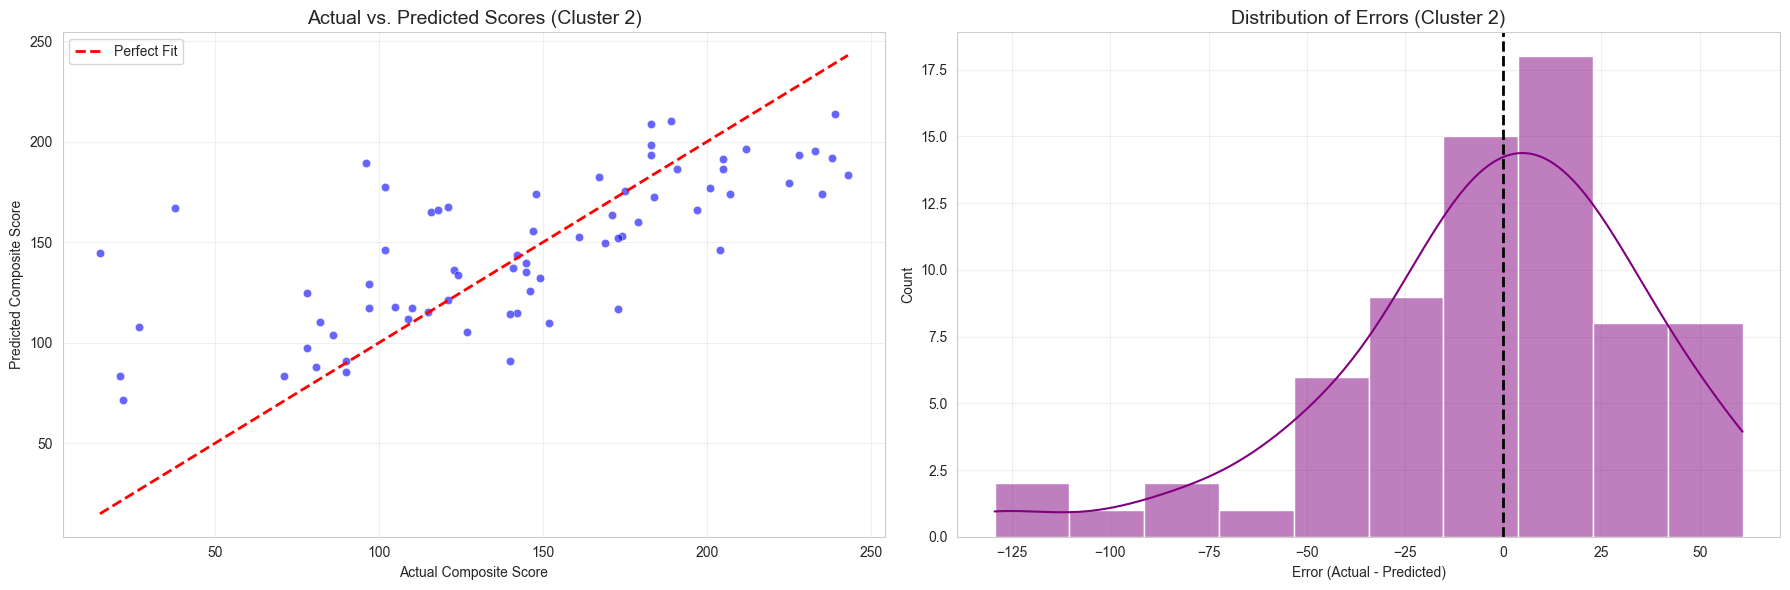

Performance Stats for Cluster 2:
- Mean Absolute Error (MAE): 29.48
- Std Dev of Error:          39.98
- Correlation (Actual/Pred): 0.712

   >>> DETAILED ANALYSIS FOR CLUSTER 3 <<<

Sample Predictions (Cluster 3):


,Actual,Predicted,Error,Abs_Error
1304,110,102.160167,7.839833,7.839833
2280,108,139.310583,-31.310583,31.310583
529,24,212.378667,-188.378667,188.378667
787,194,170.837500,23.162500,23.162500
2137,211,227.931167,-16.931167,16.931167


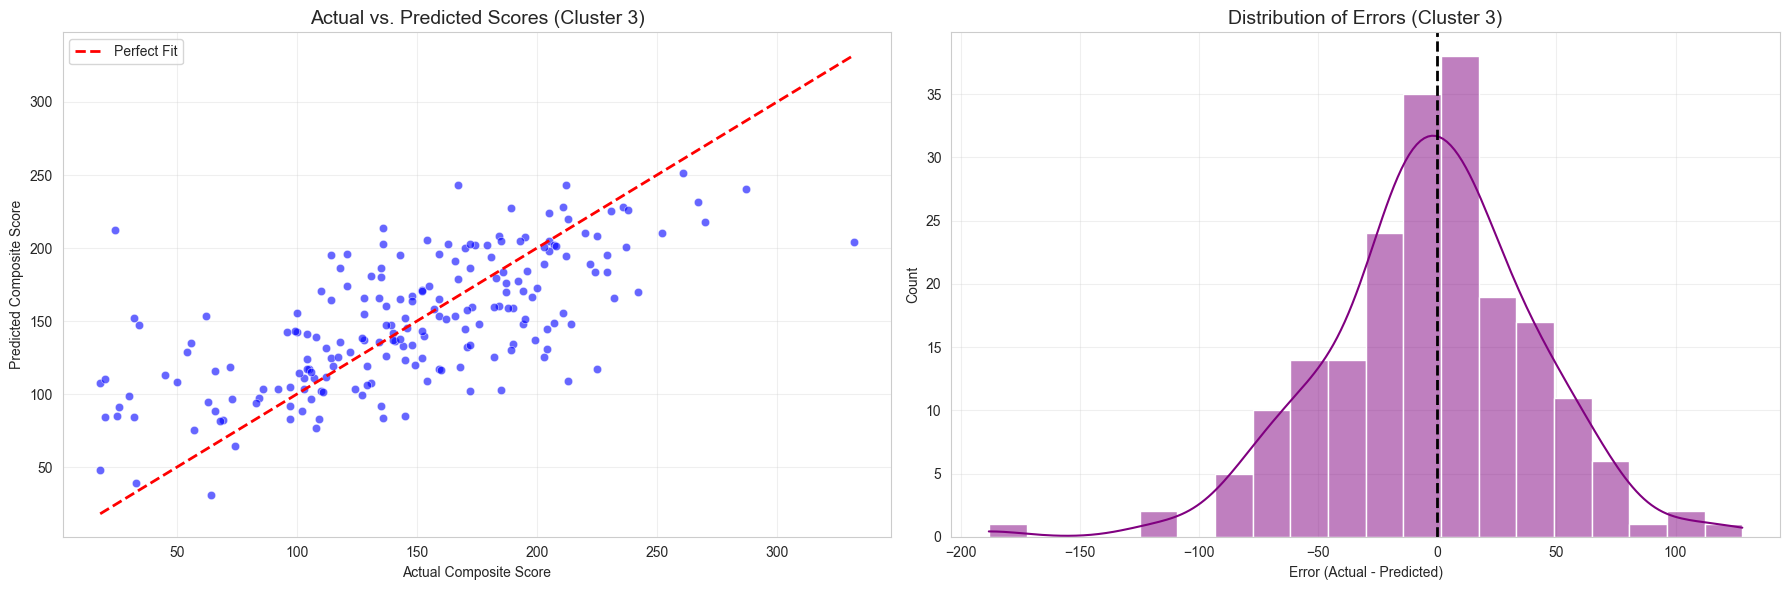

Performance Stats for Cluster 3:
- Mean Absolute Error (MAE): 32.96
- Std Dev of Error:          43.47
- Correlation (Actual/Pred): 0.676

   >>> DETAILED ANALYSIS FOR CLUSTER 5 <<<

Sample Predictions (Cluster 5):


,Actual,Predicted,Error,Abs_Error
2140,191,222.722583,-31.722583,31.722583
2844,198,206.853333,-8.853333,8.853333
1062,257,243.512917,13.487083,13.487083
2779,172,164.023333,7.976667,7.976667
657,118,150.514583,-32.514583,32.514583


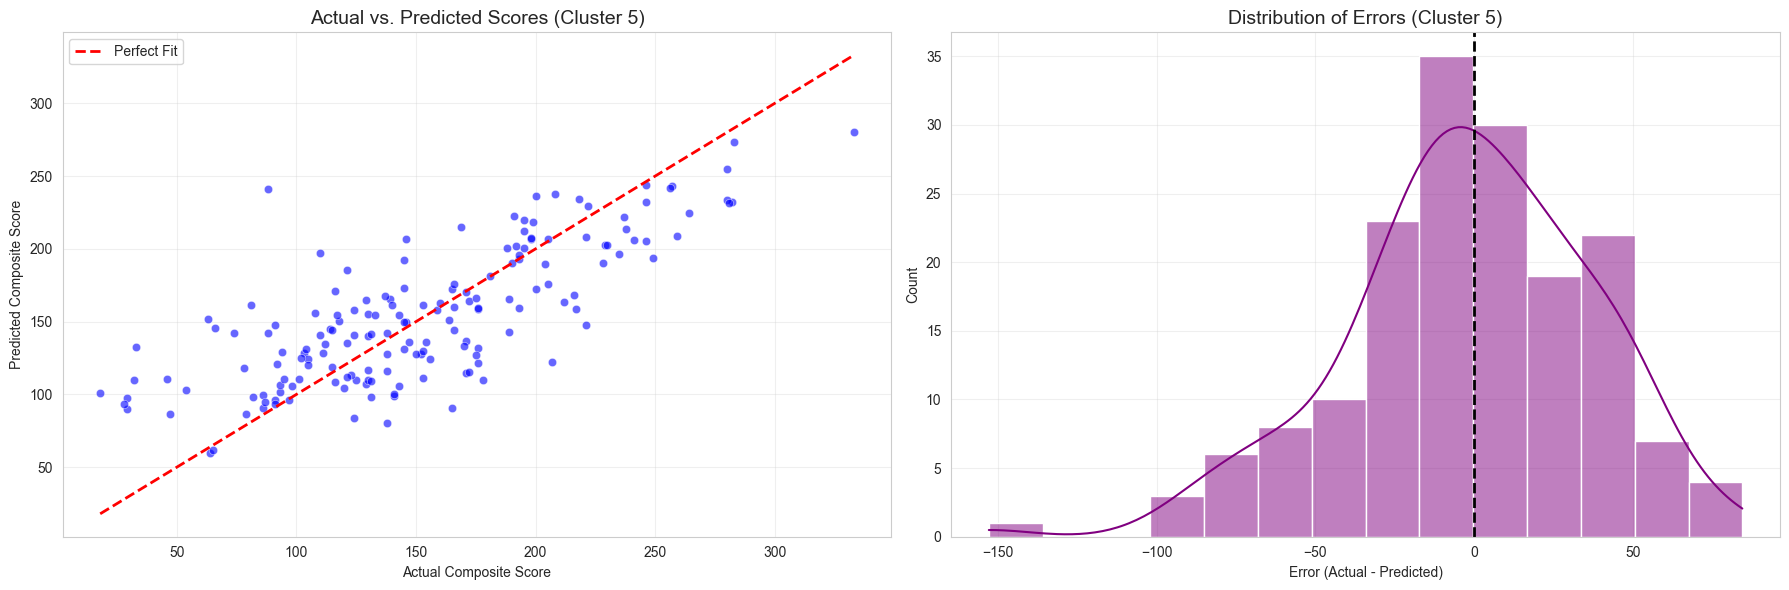

Performance Stats for Cluster 5:
- Mean Absolute Error (MAE): 29.98
- Std Dev of Error:          38.58
- Correlation (Actual/Pred): 0.771


In [9]:


# Define the list of "Good" clusters you want to inspect
clusters_to_inspect = [2, 3, 5]

print(f"Starting detailed inspection for clusters: {clusters_to_inspect}")

for target_cluster in clusters_to_inspect:
    
    # --- 1. Setup & Calculations ---
    print("\n" + "="*80)
    print(f"   >>> DETAILED ANALYSIS FOR CLUSTER {target_cluster} <<<")
    print("="*80)

    # Retrieve data
    data_pack = specialist_models[target_cluster]
    y_test_actual = data_pack['y_test']
    y_test_pred = data_pack['preds']

    # Create Comparison DataFrame
    comparison_df = pd.DataFrame({
        'Actual': y_test_actual,
        'Predicted': y_test_pred
    })

    # Calculate Residuals
    comparison_df['Error'] = comparison_df['Actual'] - comparison_df['Predicted']
    comparison_df['Abs_Error'] = comparison_df['Error'].abs()

    # Display a sample of the raw data comparison
    print(f"\nSample Predictions (Cluster {target_cluster}):")
    display(comparison_df.head(5))

    # --- 2. Visualization (Side-by-Side) ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # PLOT A: Scatter Plot (Actual vs Predicted)
    sns.scatterplot(x='Actual', y='Predicted', data=comparison_df, alpha=0.6, color='blue', ax=axes[0])
    
    # Perfect Prediction Line
    min_val = min(comparison_df['Actual'].min(), comparison_df['Predicted'].min())
    max_val = max(comparison_df['Actual'].max(), comparison_df['Predicted'].max())
    axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')
    
    axes[0].set_title(f"Actual vs. Predicted Scores (Cluster {target_cluster})", fontsize=14)
    axes[0].set_xlabel("Actual Composite Score")
    axes[0].set_ylabel("Predicted Composite Score")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # PLOT B: Error Distribution
    sns.histplot(comparison_df['Error'], kde=True, color='purple', ax=axes[1])
    axes[1].axvline(0, color='black', linestyle='--', linewidth=2)
    axes[1].set_title(f"Distribution of Errors (Cluster {target_cluster})", fontsize=14)
    axes[1].set_xlabel("Error (Actual - Predicted)")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- 3. Statistical Summary ---
    print(f"Performance Stats for Cluster {target_cluster}:")
    print(f"- Mean Absolute Error (MAE): {comparison_df['Abs_Error'].mean():.2f}")
    print(f"- Std Dev of Error:          {comparison_df['Error'].std():.2f}")
    print(f"- Correlation (Actual/Pred): {comparison_df['Actual'].corr(comparison_df['Predicted']):.3f}")

<hr>

### What to look for in these plots:

**1) The Scatter Plot (Left):**

- Ideally: All blue dots should hug the red dashed line tightly.
- Cluster 5: You should see a tight cigar shape along the line (High R2).
- Cluster 2: Similar tight shape.

**2) The Histogram (Right):**

- Ideally: A tall, narrow bell curve centered exactly on 0.
- Bias: If the curve is shifted to the left or right of the black line, your model is consistently over-estimating or under-estimating.
- Spread: A wider curve means more "big misses" (higher variance).

<hr>

### Performance Analysis: `Cluster 2`

**Overall Trend (Good):**
    
    The scatter plot shows a strong positive correlation, particularly for individuals with scores above `100`. For the majority of this `"average"` group, the model predicts the composite score with reasonable accuracy (the dots cluster around the red dashed line).
    
**The "Blind Spot" (Low Score Outliers):** 

    The model struggles significantly with individuals in this cluster who have very low actual scores (below 50).
    - Evidence: Look at the table sample. For `ID 2359`, the actual score is `38`, but the model predicted `167` (an error of 129 points).
    - Visual: In the scatter plot, look at the bottom-left. There are blue dots where the Actual is low (~25-50), but the Prediction remains high (~100-150).


**Interpretation:** 

    Because this cluster represents `"Working/Active"` people, the model assumes they are generally `healthy` and predicts `high scores` by default. It fails to catch the subtle hidden factors causing severe cognitive decline in these specific working individuals.


**Verdict:** The model is reliable for the majority of this group but tends to over-estimate the health of the few lowest-performing members.

<hr>

### Performance Analysis: `Cluster 3`

**Overall Performance (Solid but Noisy):**

    With a correlation of `0.676`, the model generally understands this group well. The histogram is nicely centered on zero, meaning the model is unbiased—it doesn't systematically guess too high or too low for the average person.
  
**The "Catastrophic" Outlier:**

    There is a massive error that defines this plot. Look at ID 529 in the table:

    - Actual Score: 24 (Severe impairment)
    - Predicted Score: 212 (Excellent health)
    - The Error: The model missed by 188 points.

**Interpretation (The "Homemaker Halo" Effect):**

    Since this cluster consists of non-working individuals relying on spousal income, the model likely sees a "financially stable, married homemaker" and assumes they are healthy. It completely missed the specific, hidden health crisis that caused the score of 24, effectively "stereotyping" the patient based on their stable environment.

**Verdict:** A good model for the general population, but it can fail dangerously on individuals who look `"stable"` on paper `(financially/socially)` but have severe, unmeasured medical events.

<hr>

### Performance Analysis: `Cluster 5`

**The "Star" Performer:**

    This cluster has the cleanest scatter plot of all. The blue dots form a tight, consistent "cigar shape" along the red line. This confirms why this cluster had the highest R2 (0.59). The relationship between "Professional Success" (Jobs/Income) and "Cognitive Health" is very strong and linear, making this group the easiest for the AI to understand.

**Regression to the Mean (The "Flattening"):**

    Notice the behavior at the extremes.
    - At the top right (Actual > 300): The model underestimates (predicts ~275). It struggles to predict "superhuman" scores.
    - At the bottom left (Actual < 100): The model overestimates. It sees a "Wealthy Professional" and assumes they must be healthy, predicting a score of ~100 even when the actual score is lower.

**The "Safety" Zone:**

    Unlike Clusters 2 and 3, there are almost no catastrophic outliers (dots far away from the main group). The error histogram is a tall, narrow bell curve, proving that even when the model is wrong, it is usually only wrong by a small amount (~30 points).

**Verdict:** This is the most robust and reliable model. The strong correlation between socioeconomic status and health in this group makes predictions highly accurate and stable.

<hr>

## Comparison between Training with Cluster or Without Clusters

<hr>

<div style="display: flex; justify-content: space-around;">
    <img src="..//visualization//results-with-clusters.png" width="40%" />
    <img src="..//visualization//results-without-clusters.png" width="55%" />
</div>

**This is a definitive success. The "Divide and Conquer" (Clustering) strategy has significantly outperformed your previous Global Model.**

Here is the quick data-driven verdict:

**The Verdict: Clustering Brought Major Improvements.**

Previous `Global Model (WeightedEnsemble_L2)` was "stuck in the middle." By trying to find one rule for everyone, it became mediocre for everyone.

**Evidence of Improvement:**

1) Massive Accuracy Gains for the Majority:

- `Global Model R2: 0.38`
- `Cluster 5` (Professionals): 0.59 (+21% jump in explanatory power)
- `Cluster 2` (Working Middle): 0.50 (+12% jump)
- **Takeaway:** Largest and most stable groups, the specialist models are far superior.
  
2) Reduction in Error (MAE):
   
- `Global Model MAE: 35.19` (On average, it missed by 35 points).
- `Cluster 5` Model: 29.98 (~5 points better)
- `Cluster 2` Model: 29.47 (~6 points better)
- `Cluster 0` Model: 33.51 (~1.5 points better)
- **Takeaway:** Every single major cluster model predicts closer to the truth than the global model did.

3) Handling Complexity:

The Global Model had an `RMSE of 45.8`.

- Specialist models for` Clusters 2, 3, and 5` all have `RMSEs below 43`, with `Cluster 5 dropping to 38.5`.
- This means the specialist models are much less prone to making "huge" wild guesses for the healthy population.

**Why the Global Model Failed (Comparatively)**

The Global Model was being "confused" by the Frail (Cluster 0) and Wealthy (Cluster 1) groups.

- It couldn't learn that "Income" is good for Cluster 5 but irrelevant for Cluster 0.
- By separating them, you allowed the Cluster 5 model to fully utilize income/job data without being held back by the Frail group's data patterns.

## Conclusion

`Keep the Clustering Strategy`. We moved from a model that `explained 38%` of the variance to a system that explains `50-60%` of the variance for our core population. That is a massive leap in Data Science terms.